In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib

In [2]:
intakes  = "https://data.austintexas.gov/api/views/wter-evkm/rows.csv?accessType=DOWNLOAD"
outcomes = "https://data.austintexas.gov/api/views/9t4d-g238/rows.csv?accessType=DOWNLOAD"
df_intakes  = pd.read_csv(intakes)
df_outcomes = pd.read_csv(outcomes)

In [3]:
df_intakes.columns = df_intakes.columns.str.lower().str.replace(" ", "_")
df_intakes.columns

Index(['animal_id', 'name', 'datetime', 'monthyear', 'found_location',
       'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake',
       'age_upon_intake', 'breed', 'color'],
      dtype='object')

In [4]:
df_outcomes.columns = df_outcomes.columns.str.lower().str.replace(" ", "_")
df_outcomes.columns

Index(['animal_id', 'date_of_birth', 'name', 'datetime', 'monthyear',
       'outcome_type', 'outcome_subtype', 'animal_type', 'sex_upon_outcome',
       'age_upon_outcome', 'breed', 'color'],
      dtype='object')

In [5]:
# from outcomes selecting only the important columns 'animal_id', 'datetime','outcome_type' 
df_outcomes = df_outcomes[['animal_id', 'datetime', 'outcome_type']]

In [7]:
# merging the two dataframes on 'animal_id', just using the animals that are present in both dataframes as for the rest we dont have the outcome
df = pd.merge(df_intakes, df_outcomes, on='animal_id', how='inner', suffixes=('_intake', '_outcome'))
df.head()

,animal_id,name,datetime_intake,monthyear,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type
0,A521520,Nina,10/01/2013 07:51:00 AM,October 2013,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,2013-10-01T15:39:00,Return to Owner
1,A664235,NaN,10/01/2013 08:33:00 AM,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01T10:39:00,Transfer
2,A664236,NaN,10/01/2013 08:33:00 AM,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01T10:44:00,Transfer
3,A664237,NaN,10/01/2013 08:33:00 AM,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01T10:44:00,Transfer
4,A664233,Stevie,10/01/2013 08:53:00 AM,October 2013,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,2013-10-01T15:33:00,Euthanasia


In [8]:
df.shape

(221246, 14)

In [13]:
animal_id_counts = df['animal_id'].value_counts()
animal_id_counts

animal_id
A721033    1089
A718223     196
A718877     144
A705625     132
A706536     121
           ... 
A664299       1
A664300       1
A664301       1
A664305       1
A664236       1
Name: count, Length: 155423, dtype: int64

In [14]:
# Create target column
df["adopted"] = (df["outcome_type"] == "Adoption").astype(int)

<Axes: xlabel='outcome_type'>

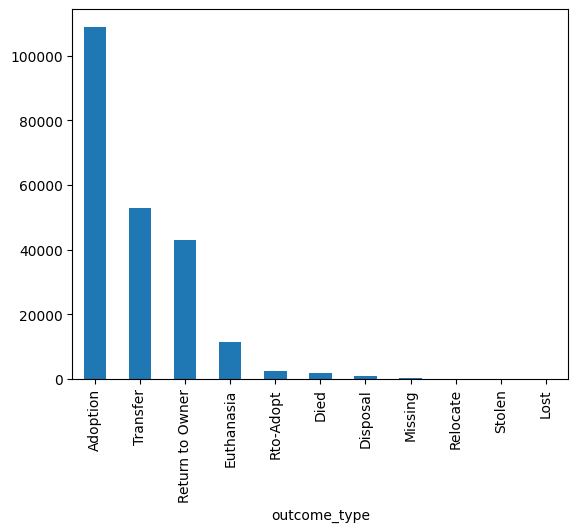

In [31]:
# animals by outcome_type in graph 
df['outcome_type'].value_counts().plot.bar()

In [15]:
# Fill missing values
df = df.fillna({
    "intake_type": "Unknown",
    "intake_condition": "Unknown",
    "sex_upon_intake": "Unknown",
    "monthyear": "Unknown"
})

In [16]:
df.dtypes


animal_id           object
name                object
datetime_intake     object
monthyear           object
found_location      object
intake_type         object
intake_condition    object
animal_type         object
sex_upon_intake     object
age_upon_intake     object
breed               object
color               object
datetime_outcome    object
outcome_type        object
adopted              int64
dtype: object

In [17]:
# Convert monthyear to numeric features
# ----------------------------
df["monthyear"] = pd.to_datetime(df["monthyear"], errors='coerce')
df["month"] = df["monthyear"].dt.month.fillna(0).astype(int)
df["year"] = df["monthyear"].dt.year.fillna(0).astype(int)

C:\Users\snigd\AppData\Local\Temp\ipykernel_26176\3885704529.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["monthyear"] = pd.to_datetime(df["monthyear"], errors='coerce')


In [18]:
# Encode categorical features
# ----------------------------
categorical_features = ["intake_type", "intake_condition", "animal_type",
                        "sex_upon_intake", "breed", "color"]

In [19]:
from sklearn.feature_extraction import DictVectorizer
# Copy dataframe
df_features = df.copy()

In [20]:
# Convert categorical columns to dict
cat_dicts = df_features[categorical_features].to_dict(orient='records')

In [21]:
# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

In [22]:
# Fit and transform
X_cat = dv.fit_transform(cat_dicts)

In [23]:
# X_cat is now a numeric array for categorical features
print(X_cat.shape)

(221246, 3698)


In [24]:
# Optionally, combine with numeric columns
numeric_features = ["month", "year"]  # if you extracted month/year
X_numeric = df_features[numeric_features].values

In [26]:
import numpy as np
X = np.hstack([X_numeric, X_cat])
y = df["adopted"].values

In [27]:
# Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Train RandomForest
# ----------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# Evaluate
# ----------------------------
y_pred = model.predict(X_test)
print("F1-score:", f1_score(y_test, y_pred))

F1-score: 0.6938123213361245


In [30]:
# Save model and DictVectorizer
# ----------------------------
joblib.dump(model, "model.joblib")
joblib.dump(dv, "dictvectorizer.joblib")
print("Model and DictVectorizer saved successfully!")

Model and DictVectorizer saved successfully!
